In [52]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [53]:
def read_manual_scores(manual_accuracy_dir, task, score_type):
    manualStory1File = os.path.join(manual_accuracy_dir, task+'1_manual_' + score_type + '.csv')
    manualStory2File = os.path.join(manual_accuracy_dir, task+'2_manual_' + score_type + '.csv')
    manualStory3File = os.path.join(manual_accuracy_dir, task+'3_manual_' + score_type + '.csv')

    # Read input files as dataframe
    manualStory1DF = pd.read_csv(manualStory1File, index_col=0)
    manualStory2DF = pd.read_csv(manualStory2File, index_col=0)
    manualStory3DF = pd.read_csv(manualStory3File, index_col=0)

    # print('a', [len(x) for x in [manualStory1DF, manualStory2DF,manualStory3DF]])

    # Remove speakers with missing accuracy scores
    manualStory1DF = manualStory1DF.dropna()
    manualStory2DF = manualStory2DF.dropna()
    manualStory3DF = manualStory3DF.dropna()

    # print('b', [len(x) for x in [manualStory1DF, manualStory2DF,manualStory3DF]])


    return manualStory1DF, manualStory2DF, manualStory3DF

def read_automatic_scores(asr_accuracy_dir, task, score_type):

    asrStory1File = os.path.join(asr_accuracy_dir, task+'1Asr' + score_type + 'DF.tsv')
    asrStory2File = os.path.join(asr_accuracy_dir, task+'2Asr' + score_type + 'DF.tsv')
    asrStory3File = os.path.join(asr_accuracy_dir, task+'3Asr' + score_type + 'DF.tsv')

    asrStory1DF = pd.read_csv(asrStory1File, index_col=0, sep = '\t')
    asrStory2DF = pd.read_csv(asrStory2File, index_col=0, sep = '\t')
    asrStory3DF = pd.read_csv(asrStory3File, index_col=0, sep = '\t')

    # print('1', [len(x) for x in [asrStory1DF, asrStory2DF,asrStory3DF]])

    asrStory1DF = asrStory1DF.dropna()
    asrStory2DF = asrStory2DF.dropna()
    asrStory3DF = asrStory3DF.dropna()

    # print('2', [len(x) for x in [asrStory1DF, asrStory2DF,asrStory3DF]])

    return asrStory1DF, asrStory2DF, asrStory3DF

In [54]:
manual_score_types = ['chunk_starttime', 'chunk_endtime', 'chunk_duration', 'finalattempt_starttime', 'finalattempt_endtime', 'finalattempt_duration']
asr_score_types = ['Accuracy', 'Confidence', 'StartSpeak', 'StopSpeak', 'Time']

manual_asr_score_dict = {  'chunk_starttime': 'StartSpeak', 
                        'chunk_endtime': 'StopSpeak',
                        'chunk_duration': 'Time',
                        'finalattempt_starttime': 'StartSpeak',
                        'finalattempt_endtime': 'StopSpeak',
                        # 'finalattempt_duration': 'Time'
                        }


In [55]:
def extractStats(differenceStoryDF, taskName):
    outputDescriptiveStatsOneTask = []
    for studentID, row in differenceStoryDF.iterrows():
            
        scores = np.array(row).flatten()

        descriptiveStats = pd.Series(scores).describe()
        count = descriptiveStats['count']
        mean = descriptiveStats['mean']
        std = descriptiveStats['std']
        minn = descriptiveStats['min']
        perc25 = descriptiveStats['25%']
        perc50 = descriptiveStats['50%']
        perc75 = descriptiveStats['75%']
        maxx = descriptiveStats['max']

        # The mean should be very close to zero
        outputDescriptiveStatsOneTask.append('\t'.join([taskName, studentID]+[str(round(nr, 3)) for nr in [mean, std, minn, perc25, perc50, perc75, maxx]]))
    return np.array(outputDescriptiveStatsOneTask)


In [56]:
task = 'story'
manual_accuracy_dir = '/vol/tensusers2/wharmsen/SERDA-annotations/round1_stories_all_11jan/03_scoring_csv'
outputDir = ''
asrModelName='whispert_dis'

asr_accuracy_dir = '/vol/tensusers2/wharmsen/SERDA-experiment-data/round1/stories_manann_11jan/whispert_dis/csv-scores'
header = ['\t'.join(["task", "studentID", "mean", "std", "min", "perc25", "perc50", "perc75", "max"])]

# print(['story1', 'story2', 'story3'])

outputDescriptiveStats = []
for (manual_key, asr_key) in manual_asr_score_dict.items():

    print('\n', manual_key, asr_key)

    # Read the scores
    manualStory1DF, manualStory2DF, manualStory3DF = read_manual_scores(manual_accuracy_dir, task, manual_key)

    # Preprocess ASR DFs
    manualStory1DF = manualStory1DF.replace(0.0, np.nan).replace(999, np.nan)
    manualStory2DF = manualStory2DF.replace(0.0, np.nan).replace(999, np.nan)
    manualStory3DF = manualStory3DF.replace(0.0, np.nan).replace(999, np.nan)

    # print('c', [len(x) for x in [manualStory1DF, manualStory2DF,manualStory3DF]])

    # Preprocess Manual DFs
    asrStory1DF, asrStory2DF, asrStory3DF = read_automatic_scores(asr_accuracy_dir, task, asr_key)

    asrStory1DF = asrStory1DF.loc[manualStory1DF.index].replace(0.0, np.nan).replace(999, np.nan)
    asrStory2DF = asrStory2DF.loc[manualStory2DF.index].replace(0.0, np.nan).replace(999, np.nan)
    asrStory3DF = asrStory3DF.loc[manualStory3DF.index].replace(0.0, np.nan).replace(999, np.nan)

    # print('3', [len(x) for x in [asrStory1DF, asrStory2DF,asrStory3DF]])

    # Subtract DFs
    differenceStory1DF = manualStory1DF - asrStory1DF
    differenceStory2DF = manualStory2DF - asrStory2DF
    differenceStory3DF = manualStory3DF - asrStory3DF

    # print('DIFF', [len(x) for x in [differenceStory1DF, differenceStory2DF,differenceStory3DF]])

    # Compute statistics for each speaker
    statsStory1 = extractStats(differenceStory1DF, 'story1')
    statsStory2 = extractStats(differenceStory2DF, 'story2')
    statsStory3 = extractStats(differenceStory3DF, 'story3')

    outputDescriptiveStats = list(np.concatenate((header, statsStory1, statsStory2, statsStory3), axis=0))
    # print(outputDescriptiveStats)
    
        
    # print(outputDescriptiveStats)
    with open(manual_key + '-' + asr_key + '-output.tsv', 'w') as f:
        f.write('\n'.join(outputDescriptiveStats))


 chunk_starttime StartSpeak

 chunk_endtime StopSpeak

 chunk_duration Time

 finalattempt_starttime StartSpeak

 finalattempt_endtime StopSpeak


In [80]:
differenceStory1DF['0-0-Bang'].mean()

0.07131012382593986

In [59]:
asrStory3DF.loc['YWPWY']

0-0-Verslaafd     NaN
1-0-Als          6.34
1-1-ouders       7.10
1-2-zien         7.40
1-3-dat          7.74
                 ... 
11-6-je           NaN
11-7-aan          NaN
11-8-het          NaN
11-9-spelen       NaN
11-10-bent        NaN
Name: YWPWY, Length: 172, dtype: float64

In [62]:
manualStory3DF.loc['YWPWY']

0-0-Verslaafd      4.996980
1-0-Als            6.588618
1-1-ouders         7.108734
1-2-zien           7.453099
1-3-dat            7.717672
                    ...    
11-6-je          138.726604
11-7-aan         139.927682
11-8-het         140.196455
11-9-spelen      140.846539
11-10-bent       141.774644
Name: YWPWY, Length: 172, dtype: float64

In [61]:
differenceStory3DF.loc['YWPWY']

0-0-Verslaafd         NaN
1-0-Als          0.248618
1-1-ouders       0.008734
1-2-zien         0.053099
1-3-dat         -0.022328
                   ...   
11-6-je               NaN
11-7-aan              NaN
11-8-het              NaN
11-9-spelen           NaN
11-10-bent            NaN
Name: YWPWY, Length: 172, dtype: float64

In [63]:
np.count_nonzero(~np.isnan(list(differenceStory3DF.loc['YWPWY'])))

78

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 77.]),
 array([-117.59917614, -105.59209714,  -93.58501813,  -81.57793913,
         -69.57086013,  -57.56378113,  -45.55670213,  -33.54962313,
         -21.54254412,   -9.53546512,    2.47161388]),
 <BarContainer object of 10 artists>)

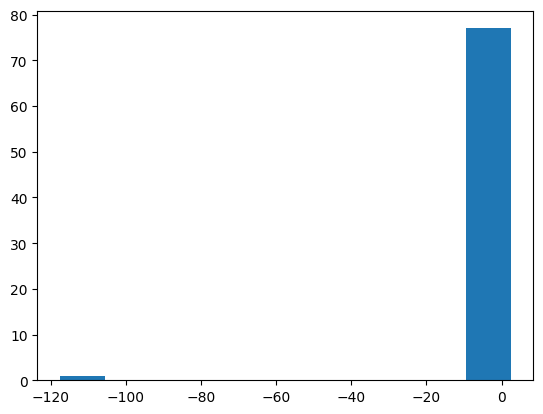

In [65]:
plt.hist(list(differenceStory3DF.loc['YWPWY']))

In [73]:
differenceStory3DF.to_csv('output.tsv', sep = '\t')

In [64]:
differenceStory3DF.loc['YWPWY'].describe()

count     78.000000
mean      -1.391011
std       13.331987
min     -117.599176
25%        0.013767
50%        0.078219
75%        0.158015
max        2.471614
Name: YWPWY, dtype: float64

In [75]:
differenceStory3DF.loc['YWPWY', '1-18-aan']

-117.59917613763187

In [77]:
asrStory3DF.loc['YWPWY', '1-18-aan']

139.7

In [76]:
manualStory3DF.loc['YWPWY', '1-18-aan']

22.100823862368117

In [37]:
[0,1,2,1].count(1)

2

In [167]:
[str(x)+str(y) for x in [0,0,0] for y in [1,1,1] ]


['01', '01', '01', '01', '01', '01', '01', '01', '01']

In [51]:
task = 'story'
manual_accuracy_dir = '/vol/tensusers2/wharmsen/SERDA-annotations/round1_stories_all_11jan/03_scoring_csv'
manualStory1DF, manualStory2DF, manualStory3DF = read_manual_scores(manual_accuracy_dir, task, 'chunk_starttime')
outputDir = ''
asrModelName='whispert_dis'

asr_accuracy_dir = '/vol/tensusers2/wharmsen/SERDA-experiment-data/round1/stories_manann_11jan/whispert_dis/csv-scores'
asrStory1DF, asrStory2DF, asrStory3DF = read_automatic_scores(asr_accuracy_dir, task, 'StartSpeak')

print(len(manualStory1DF.index))
print(len(asrStory1DF.index))
print(len(set(manualStory1DF+asrStory1DF)))
print(sorted(manualStory1DF.index)[0:20])
print(sorted(asrStory1DF.index)[0:20])

2
10
174
['Z2BYD', 'ZDPNZ']
['SMVCS', 'XSWMB', 'YHTKC', 'YKKTR', 'YVBRP', 'Z2BYD', 'ZDPNZ', 'ZNNGY', 'ZPGND', 'ZRYSY']


In [60]:
# In asr timings: replace 0.0 with np.nan
# asrStory1DF = [np.nan if x==0.0 else x for x in list(np.array(asrStory1DF).flatten())]
asrStory1DF = asrStory1DF.loc[manualStory1DF.index].replace(0.0, np.nan).replace(999, np.nan)
asrStory1DF

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
Z2BYD,NaN,2.50,2.76,3.24,4.28,4.54,NaN,6.58,6.98,7.48,...,92.14,NaN,93.48,NaN,NaN,96.70,97.92,NaN,NaN,NaN
ZDPNZ,2.96,3.22,3.50,3.66,5.60,5.86,6.04,6.38,7.00,8.92,...,116.00,NaN,116.38,NaN,NaN,119.66,NaN,NaN,NaN,NaN


In [61]:
manualStory1DF

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
Z2BYD,1.592487,2.539807,2.748852,3.420973,4.265572,4.803234,5.989206,6.579623,7.113180,7.448758,...,92.192542,92.487830,93.534866,95.445759,95.764352,96.788808,97.837448,98.599460,98.921850,99.258894
ZDPNZ,3.002905,3.293981,3.452750,3.680318,5.651853,5.923873,6.058045,6.523051,7.041001,9.058533,...,115.872978,116.247924,116.417017,119.218084,119.482751,119.732715,121.764616,122.698304,122.916393,123.247228


In [62]:
differenceDF = manualStory1DF - asrStory1DF
differenceDF

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
Z2BYD,NaN,0.039807,-0.011148,0.180973,-0.014428,0.263234,NaN,-0.000377,0.133180,-0.031242,...,0.052542,NaN,0.054866,NaN,NaN,0.088808,-0.082552,NaN,NaN,NaN
ZDPNZ,0.042905,0.073981,-0.047250,0.020318,0.051853,0.063873,0.018045,0.143051,0.041001,0.138533,...,-0.127022,NaN,0.037017,NaN,NaN,0.072715,NaN,NaN,NaN,NaN


In [63]:
for idx, row in differenceDF.iterrows():
    for column in differenceDF.columns:
        if row[column] <-700:
            print(idx, column)

In [64]:
asrStory1DF.loc['Z2BYD', '15-1-rilt']

nan

In [65]:
manualStory1DF.loc['Z2BYD', '15-1-rilt']

73.58561307290553

(array([ 2.,  1.,  2.,  3., 11., 55., 88., 26.,  7.,  3.]),
 array([-0.41824492, -0.3462824 , -0.27431989, -0.20235737, -0.13039485,
        -0.05843233,  0.01353019,  0.08549271,  0.15745523,  0.22941774,
         0.30138026]),
 <BarContainer object of 10 artists>)

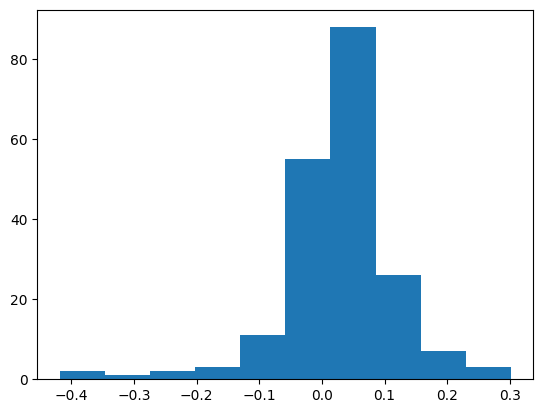

In [67]:
plt.hist(np.array(differenceDF).flatten())

In [69]:
pd.Series(np.array(differenceDF).flatten()).describe()

count    198.000000
mean       0.027831
std        0.090631
min       -0.418245
25%       -0.007664
50%        0.035159
75%        0.072263
max        0.301380
dtype: float64

In [12]:
x_manual = manualStory1DF
x_manual

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
Z2BYD,1.592487,2.539807,2.748852,3.420973,4.265572,4.803234,5.989206,6.579623,7.113180,7.448758,...,92.192542,92.487830,93.534866,95.445759,95.764352,96.788808,97.837448,98.599460,98.921850,99.258894
ZDPNZ,3.002905,3.293981,3.452750,3.680318,5.651853,5.923873,6.058045,6.523051,7.041001,9.058533,...,115.872978,116.247924,116.417017,119.218084,119.482751,119.732715,121.764616,122.698304,122.916393,123.247228


In [35]:
list(np.array(x_manual).flatten()).index(1.59248707080382)

0

In [13]:
x_asr = asrStory1DF.loc[manualStory1DF.index]
x_asr

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
Z2BYD,0.00,2.50,2.76,3.24,4.28,4.54,0.00,6.58,6.98,7.48,...,92.14,0.0,93.48,0.0,0.0,96.70,97.92,0.0,0.0,0.0
ZDPNZ,2.96,3.22,3.50,3.66,5.60,5.86,6.04,6.38,7.00,8.92,...,116.00,0.0,116.38,0.0,0.0,119.66,0.00,0.0,0.0,0.0


In [46]:
x_asr.to_numpy()

array([[  0.  ,   2.5 ,   2.76,   3.24,   4.28,   4.54,   0.  ,   6.58,
          6.98,   7.48,   8.2 ,   0.  ,   9.08,   9.52,   9.96,  10.18,
         10.5 ,  10.7 ,  11.04,  11.24,  11.98,  12.12,   0.  ,  13.12,
         13.6 ,  13.92,  14.26,  14.66,  15.02,  15.94,   0.  ,  16.26,
         16.52,  17.02,   0.  ,  17.54,  17.96,   0.  ,  20.64,  21.08,
         21.36,  22.16,  22.28,  22.92,  23.56,  23.72,  24.66,  24.84,
         25.46,  26.  ,  26.52,  27.14,  27.48,  27.86,  28.1 ,  28.48,
          0.  ,  29.88,  30.98,   0.  ,  32.06,  32.82,  33.34,   0.  ,
         34.06,  34.56,   0.  ,   0.  ,  36.24,  37.42,  37.58,  38.3 ,
          0.  ,  40.8 ,  41.54,  41.94,  42.44,  42.7 ,  43.76,  44.2 ,
          0.  ,  44.84,  45.38,   0.  ,   0.  ,   0.  ,   0.  ,  47.4 ,
         47.76,   0.  ,   0.  ,  49.62,   0.  ,   0.  ,   0.  ,   0.  ,
         51.4 ,  51.9 ,   0.  ,   0.  ,  54.34,   0.  ,  55.6 ,  56.14,
         56.72,   0.  ,   0.  ,  57.72,   0.  ,  59.  ,   0.  , 

,0-0-Bang,0-1-in,0-2-het,0-3-donker,1-0-Als,1-1-de,1-2-beker,1-3-vol,1-4-is,1-5-doet,...,19-2-sliep,19-3-ze,19-4-altijd,19-5-met,19-6-haar,19-7-broer,19-8-Hidde,19-9-op,19-10-een,19-11-kamer
Z2BYD,NaN,2.50,2.76,3.24,4.28,4.54,NaN,6.58,6.98,7.48,...,92.14,NaN,93.48,NaN,NaN,96.70,97.92,NaN,NaN,NaN
ZDPNZ,2.96,3.22,3.50,3.66,5.60,5.86,6.04,6.38,7.00,8.92,...,116.00,NaN,116.38,NaN,NaN,119.66,NaN,NaN,NaN,NaN


In [45]:
# In asr timings: replace 0.0 with np.nan
[np.nan if x==0.0 else x for x in x_asr.to_numpy()]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [26]:
one_array = np.array(x_manual-x_asr).flatten()
one_array

array([  1.59248707,   2.53980661,   2.74885198,   3.42097255,
         4.26557196,   4.80323424,   5.98920608,   6.57962307,
         7.11317973,   7.44875831,   8.22146718,   8.91417222,
         9.11992832,   9.62533388,   9.96809687,  10.18161324,
        10.56730631,  10.79299697,  11.03390519,  11.26250894,
        11.81482531,  12.15319202,  12.97807444,  13.18762788,
        13.71181088,  13.96811476,  14.43762667,  14.7540123 ,
        15.18469976,  15.88355699,  16.10190288,  16.27350361,
        16.75122682,  17.10424766,  17.40758725,  17.59282763,
        18.03259814,  20.16273165,  20.61085608,  21.08125225,
        21.37712211,  21.94423525,  22.28245933,  22.79579087,
        23.49509912,  23.77206135,  24.61979662,  24.84107332,
        25.5399306 ,  25.99187535,  26.66669239,  27.19718805,
        27.65439554,  27.92886548,  28.12229941,  28.48939314,
        29.74554418,  29.87156932,  31.05533417,  31.5657349 ,
        32.00097899,  32.90600787,  33.50918031,  33.91

In [41]:
9-np.nan

nan

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 206., 141.]),
 array([-925.41438693, -820.54822547, -715.68206402, -610.81590257,
        -505.94974112, -401.08357966, -296.21741821, -191.35125676,
         -86.48509531,   18.38106615,  123.2472276 ]),
 <BarContainer object of 10 artists>)

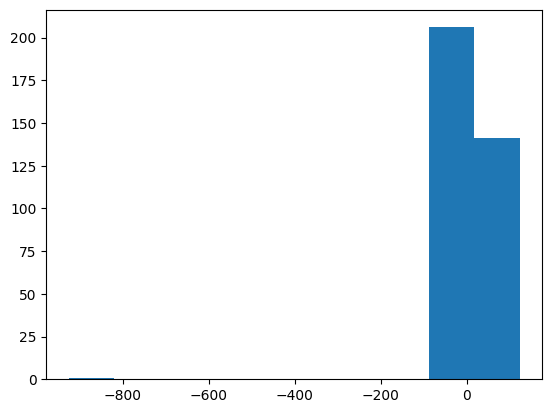

In [24]:


plt.hist(one_array)

In [ ]:
# python3 ./eval-stories-diag-metrics.py --asr_model $modelname --task $task --manual_accuracy_dir $csv_accuracy_scores_manual --asr_accuracy_dir $csv_accuracy_scores_automatic --output_dir $output_dir_eval_metrics
# def main():
#     parser = argparse.ArgumentParser("Message")
#     parser.add_argument("--asr_model", type=str, help = "The name of the ASR model.")
#     parser.add_argument("--task", type=str, help = "either story or words")
#     parser.add_argument("--manual_accuracy_dir", type=str, help = "studentID x prompt accuracy file")
#     parser.add_argument("--asr_accuracy_dir", type=str, help = "studentID x prompt accuracy file")

#     parser.add_argument("--output_dir", type=str, help = "Output directory - evaluation measures")
#     parser.set_defaults(func=run)
#     args = parser.parse_args()
#     args.func(args)

# if __name__ == "__main__":
#     main()